In [1]:
"""
SparkSession is initialized to allow for distributed data processing and analysis of the reviews data from S3 bucket
We import all required modules seaborn,matplotlib ,wordcloud and PySpark operations and other dependeices 
"""

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, lower, regexp_replace, explode, split
from pyspark.sql.types import StringType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from wordcloud import wordcloud, STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
#Initialize Spark Session
spark = SparkSession.builder.appName("WordCloud").getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1701494457805_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#Reading the parquet review file from the specified S3 path 
#inferSchema is set to true get the column names and the results saved in PySpark DataFrame

df = spark.read.parquet("s3://project-big-data-1/food_data/reviews.parquet", header=True,inferSchema=True)
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)

In [32]:
#%%local magic command is used to execute the cell in the local Python environment rather than in the Spark to enable visualization
%%local
%matplotlib inline

In [35]:
#We import essential modules from pyspark.sql.functions for date manipulation and other DataFrame operations.
#Change the date format to a standard easy to format to work withColumn
#creates a temporary view "yearly_reviews"of the DataFrame in the Spark SQL context , this table is what is querried to do analysis on reviews 

from pyspark.sql.functions import to_date, col, year, month, count, avg
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import date_format, concat_ws
df = df.withColumn("DateModified", to_date(df.DateModified, 'yyyy-MM-dd\'T\'HH:mm:ss\'Z\''))
df.createOrReplaceTempView("yearly_reviews")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:

# A query that reads from the temporary view "yearly_reviews" table and returns month_year_reviews
#The query aggregates and summarize data on a monthly basis, grouping by year and month
#Executes the SQL query stored in sql2 using the Spark SQL context and stores the result in month_year_reviews, a new DataFrame.
sql2 = """SELECT CONCAT(EXTRACT(YEAR FROM to_timestamp(DateModified, 'yyyy-MM-dd''T''HH:mm:ssZ')), 
                EXTRACT(MONTH FROM to_timestamp(DateModified, 'yyyy-MM-dd''T''HH:mm:ssZ'))) AS year_month_,
    COUNT(ReviewId) AS reviews, COUNT(DISTINCT AuthorId) AS authors, avg(Rating) as avg_rating
FROM yearly_reviews WHERE DateModified IS NOT NULL
GROUP BY 1 ORDER BY 1 DESC"""

month_year_reviews = spark.sql(sql2)
month_year_reviews.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- year_month_: string (nullable = true)
 |-- reviews: long (nullable = false)
 |-- authors: long (nullable = false)
 |-- avg_rating: double (nullable = true)

In [37]:
# PySpark DataFrame into a pandas DataFrame and processes the date information for further analysis.
# Then convert 'year_month_' column from a string or numeric type into a pandas datetime object
month_year_reviews = month_year_reviews.toPandas()
month_year_reviews['year_month_'] = pd.to_datetime(month_year_reviews['year_month_'], format = '%Y%m')
month_year_reviews.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  year_month_  reviews  authors  avg_rating
0  2020-09-01      712      629    3.988764
1  2020-08-01      739      645    3.987821
2  2020-07-01      946      719    4.128964
3  2020-06-01      949      806    3.953635
4  2020-05-01     1357     1194    3.946205

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

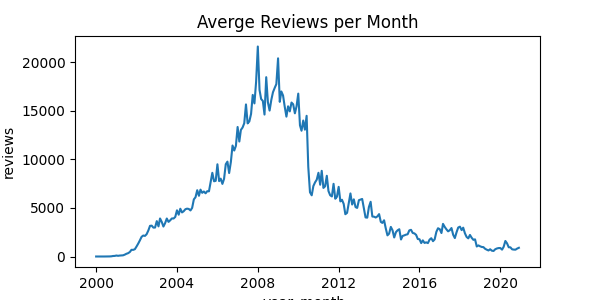

In [ ]:
#creates a line plot visualizing the number of reviews over time  using seaborn and the matplotlib
plt.clf() #clears previous plot in EMR memory
plt.figure(figsize=(6, 3))
sns.lineplot(data=month_year_reviews, x = 'year_month_', y='reviews' )
plt.title("Averge Reviews per Year")
plt.show()
#This is an IPython magic command used in Jupyter notebooks with a PySpark kernel to display matplotlib plots
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

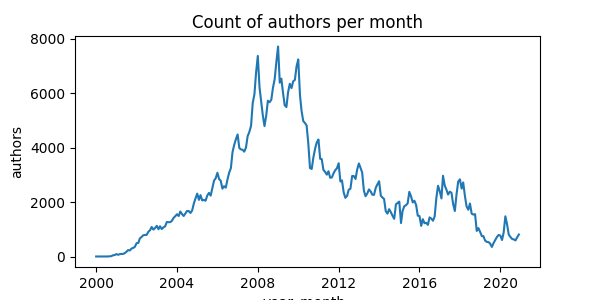

In [39]:
#using the same month_year_reviews data frame to plot count of authors per month
#Authors are considered to be reviewers

plt.clf() #clears previous plot in EMR memory
plt.figure(figsize=(6, 3))
sns.lineplot(data=month_year_reviews, x = 'year_month_', y='authors' )
plt.title("Count of authors per month")
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

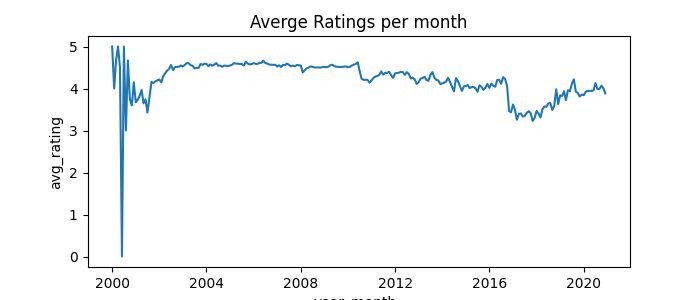

In [40]:
#using the same month_year_reviews data frame to plot Average Ratings per month

plt.clf() #clears previous plot in EMR memory
plt.figure(figsize=(7, 3))
sns.lineplot(data=month_year_reviews, x = 'year_month_', y='avg_rating' )
plt.title("Averge Ratings per month")
plt.show()

%matplot plt

In [41]:

# Defining   SQL query that retrives  yearly summary of the data, showing how many reviews were written each year and how many distinct authors contributed to those reviews. 
#The 
sql = """
SELECT EXTRACT(YEAR FROM to_timestamp(DateModified, 'yyyy-MM-dd''T''HH:mm:ssZ')) AS year_,
    COUNT(ReviewId) AS reviews, COUNT(DISTINCT AuthorId) AS authors
FROM yearly_reviews WHERE DateModified IS NOT NULL
GROUP BY EXTRACT(YEAR FROM to_timestamp(DateModified, 'yyyy-MM-dd''T''HH:mm:ssZ'))
ORDER BY 1 DESC
"""

# Execute the query and create a DataFrame
yearly_reviews = spark.sql(sql)

# Printing the shape (number of rows and columns)
print((yearly_reviews.count(), len(yearly_reviews.columns)))

# Showing the first few rows of the DataFrame
yearly_reviews.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(21, 3)
+-----+-------+-------+
|year_|reviews|authors|
+-----+-------+-------+
| 2020|  11292|   9022|
| 2019|   9475|   6668|
| 2018|  24825|  20548|
| 2017|  32266|  25773|
| 2016|  21453|  15970|
| 2015|  27636|  20032|
| 2014|  35434|  18005|
| 2013|  57623|  23301|
| 2012|  66192|  22616|
| 2011|  86178|  24573|
| 2010| 129605|  31380|
| 2009| 191722|  40515|
| 2008| 202979|  36897|
| 2007| 173397|  28216|
| 2006| 111991|  18685|
| 2005|  84913|  13422|
| 2004|  59549|  10019|
| 2003|  43820|   7474|
| 2002|  27572|   5643|
| 2001|   3904|   1735|
+-----+-------+-------+
only showing top 20 rows

In [42]:
#converting the yearly_reviews_df to a pandas data frame 
yearly_reviews_df=yearly_reviews.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

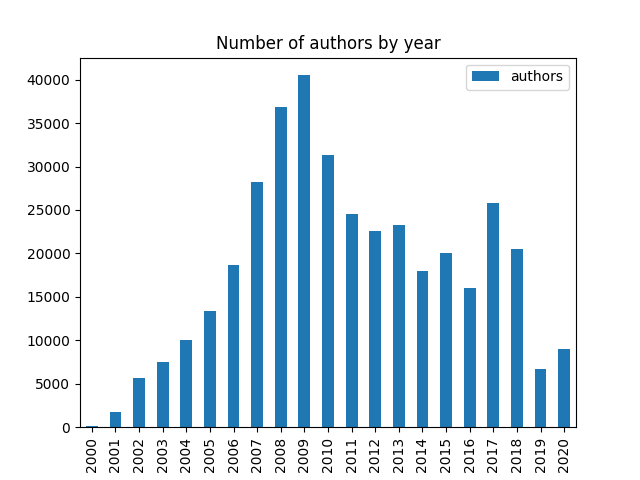

In [43]:
#using yearly_reviews_df to explore the number of authors by year 
yearly_authors = yearly_reviews_df[['year_', 'authors']]
yearly_authors = yearly_authors.set_index('year_').sort_values(by = 'year_')
#clears previous plot in EMR memory
plt.clf() 
plt.figure(figsize=(20, 20))
yearly_authors.plot.bar(title = 'Number of authors by year')
plt.show()
%matplot plt

In [44]:
#create a list of stop words and extend the list with custom words that might appear in the word cloud yet not relevant 
stop_words = list(set(STOPWORDS))
added_words = ['recipe', 'made', 'making', 'made']
stop_words.extend(added_words)
print(len(stop_words))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

196

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

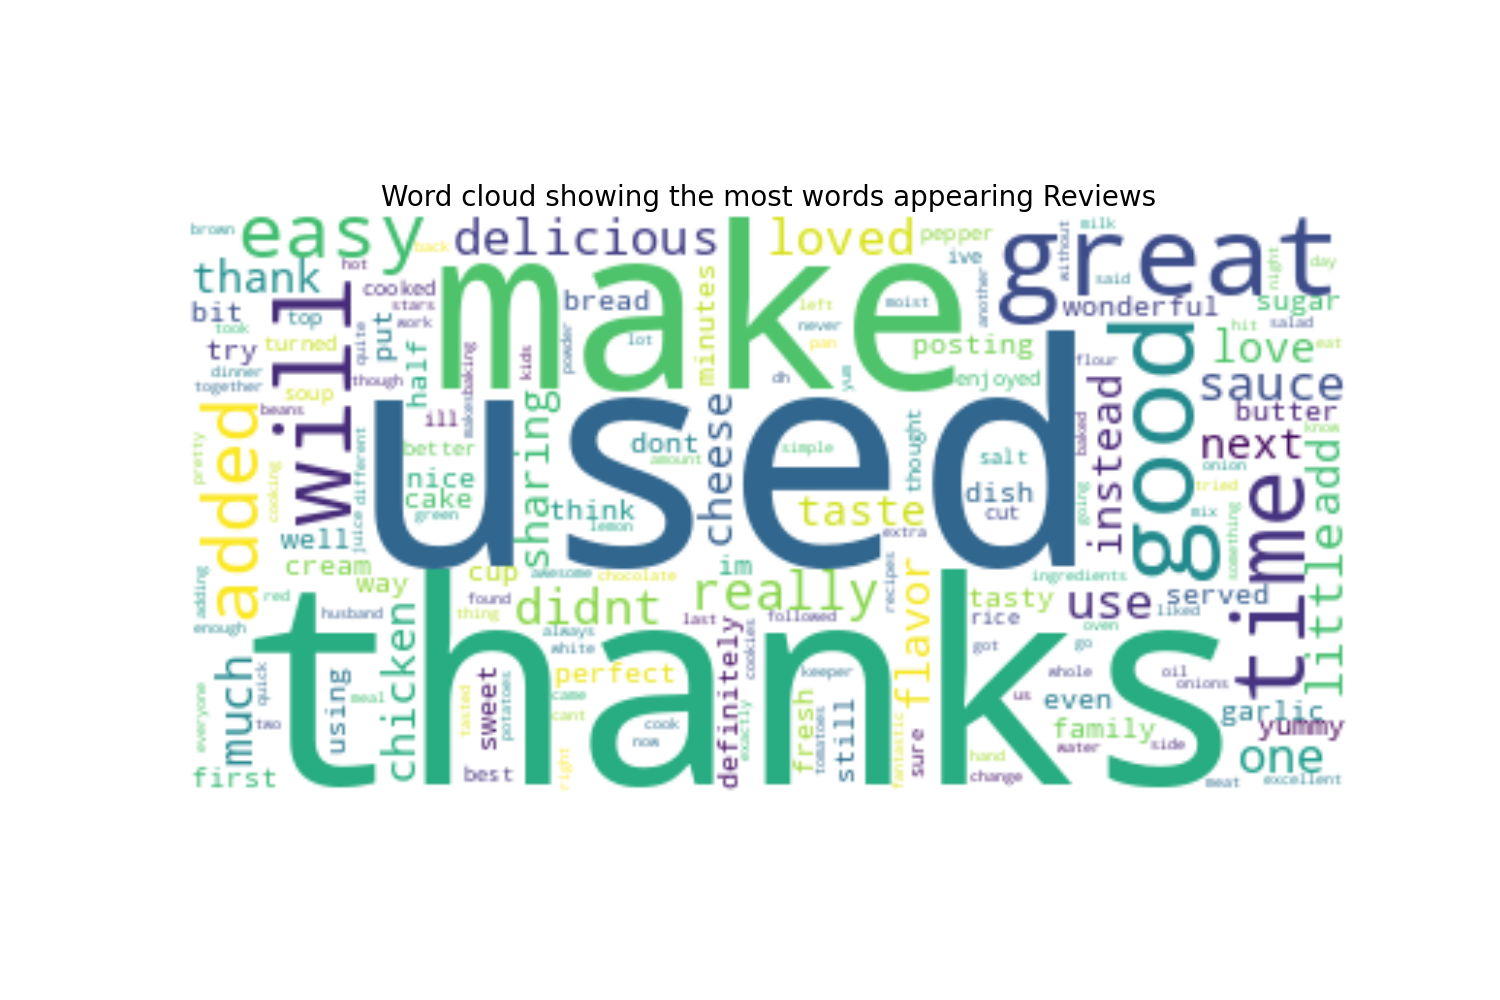

In [45]:
# Select the 'ReviewText' column and perform cleaning operations
reviews = df.select("Review").na.fill('')  # Replace nulls with empty strings
reviews = reviews.withColumn("Review", lower(col("Review")))
reviews = reviews.withColumn("Review", regexp_replace(col("Review"), "[^a-zA-Z\\s]", ""))
reviews = reviews.withColumn("Review", regexp_replace(col("Review"), "\\b(" + "|".join(stop_words) + ")\\b", ""))

# Tokenize the text into individual words and remove empty elements
words = reviews.select(explode(split(col("Review"), "\\s+")).alias("word"))
words = words.filter(col("word") != "")

# Count the frequency of each word and limit the results to reduce memory usage
word_freq = words.groupBy("word").count()
word_freq = word_freq.orderBy(col("count").desc()).limit(1000)  # Adjust the limit as needed

# Collect the top word frequencies to the driver node
word_freq_collect = word_freq.collect()

# Generate the word cloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(word_freq_collect))

# Display the word cloud using matplotlib
plt.clf() #clears previous plot in EMR memory
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud showing the most words appearing Reviews", fontsize=30)
plt.show()

%matplot plt


In [98]:
%%local
%matplotlib inline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

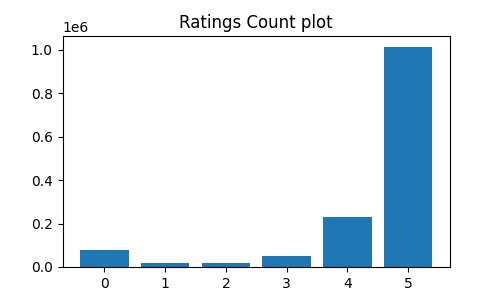

In [110]:
import time
plt.clf() #clears previous plot in EMR memory
ratings = spark.sql("select rating, count(reviewid) reviews from yearly_reviews group by rating").toPandas()

ratings = ratings.sort_values(by=['rating'], ascending=False)
plt.figure(figsize=(5, 3))
plt.bar(x=ratings['rating'], height=ratings['reviews'])
plt.title('Ratings Count plot')
time.sleep(1)
plt.savefig("plot_test.png")
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

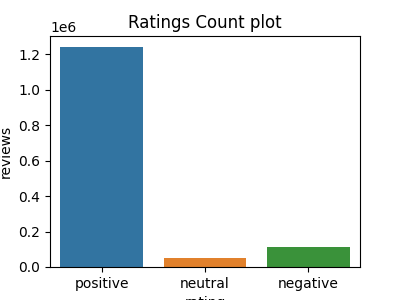

In [81]:
ratings = spark.sql("""select case when rating > 3 then 'positive'
                                   when rating == 3 then 'neutral'
                                   else 'negative' end rating, 
                                   count(reviewid) reviews from yearly_reviews group by 1""").toPandas()
plt.clf() #clears previous plot in EMR memory
plt.figure(figsize=(4, 3))
sns.barplot(x=ratings['rating'], y=ratings['reviews'])
plt.title('Sentiment Count plot')
plt.show()
%matplot plt
                                   